In [1]:
#!pip install duckdb==1.2.2
import duckdb
import pandas as pd

In [2]:
# establish connection
conn = duckdb.connect('mimic.db', read_only=False)

conn.sql('SHOW TABLES;')

┌────────────┐
│    name    │
│  varchar   │
├────────────┤
│ ADMISSIONS │
│ DRGCODES   │
│ D_ICDPROCS │
│ ICUSTAYS   │
│ PATIENTS   │
│ PROCS_ICD  │
└────────────┘

In [3]:
# Add prescriptions to the database
prescription = pd.read_csv("PRESCRIPTIONS.csv")

conn.register("new_table", prescription)
conn.execute("CREATE TABLE PRESCRIPTIONS AS SELECT * FROM new_table")
conn.unregister("new_table")

In [4]:
# Confirm prescriptions were added
conn.sql('SHOW TABLES;')

┌───────────────┐
│     name      │
│    varchar    │
├───────────────┤
│ ADMISSIONS    │
│ DRGCODES      │
│ D_ICDPROCS    │
│ ICUSTAYS      │
│ PATIENTS      │
│ PRESCRIPTIONS │
│ PROCS_ICD     │
└───────────────┘

# Analysis Question 1: Create a summary of type of drugs and their total amount used by ethnicity. Report the top usage in each ethnicity group. You may have to make certain assumptions in calculating their total amount.

In [27]:
ethnicity_drug = conn.sql(
    """
        SELECT
            ethnicity,
            drug_type,
            COUNT(*) AS total_amount
        FROM PRESCRIPTIONS
        LEFT JOIN ADMISSIONS
        ON PRESCRIPTIONS.hadm_id = ADMISSIONS.hadm_id
        GROUP BY ethnicity, drug_type
        ORDER BY ethnicity, drug_type;
    """
).df()

ethnicity_drug

,ethnicity,drug_type,total_amount
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,ADDITIVE,2
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,BASE,80
2,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,MAIN,200
3,ASIAN,BASE,56
4,ASIAN,MAIN,121
5,BLACK/AFRICAN AMERICAN,BASE,169
6,BLACK/AFRICAN AMERICAN,MAIN,476
7,HISPANIC OR LATINO,BASE,96
8,HISPANIC OR LATINO,MAIN,226
9,HISPANIC/LATINO - PUERTO RICAN,BASE,298


<Figure size 1000x600 with 0 Axes>

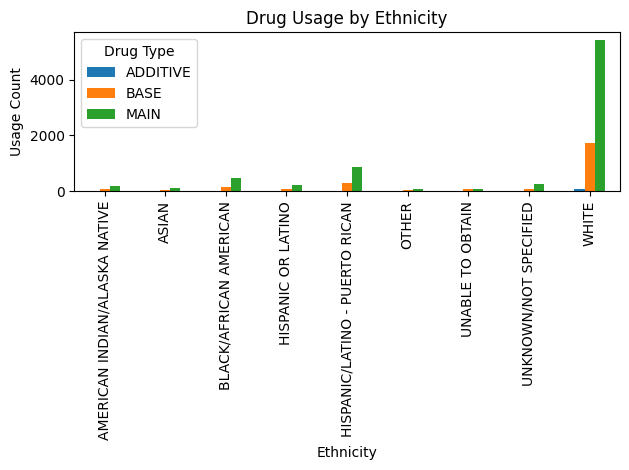

In [ ]:
# Plot drug type use by ethnicity
import numpy as np
import matplotlib.pyplot as plt

ethnicity_drug.loc[ethnicity_drug['ethnicity'] == "AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE", 'ethnicity'] = "AMERICAN INDIAN/ALASKA NATIVE"
pivot_df = ethnicity_drug.pivot(index='ethnicity', columns='drug_type', values='frequency_of_usage').fillna(0)

plt.figure(figsize=(10, 6))
pivot_df.plot(kind='bar')
plt.title('Drug Usage by Ethnicity')
plt.xlabel('Ethnicity')
plt.ylabel('Usage Count')
plt.legend(title='Drug Type')
plt.tight_layout()
plt.show()



The bar graph shows that white patients have the highest total frequency of usage across all drugs and that all ethnicities use drugs of type main the most.

In [ ]:
# Determine the most used drug type by ethnicity
conn.sql(
    '''
    WITH drug_totals AS (
        SELECT
            ethnicity,
            drug_type,
            COUNT(*) AS total_amount
        FROM PRESCRIPTIONS
        JOIN ADMISSIONS
        ON PRESCRIPTIONS.hadm_id = ADMISSIONS.hadm_id
        GROUP BY ethnicity, drug_type
    ),
    max_totals AS (
        SELECT
            ethnicity,
            MAX(total_amount) AS max_total
        FROM drug_totals
        GROUP BY ethnicity
    )
    SELECT
        drug_totals.ethnicity,
        drug_totals.drug_type,
        drug_totals.total_amount AS frequency_of_usage
    FROM drug_totals JOIN max_totals ON drug_totals.ethnicity = max_totals.ethnicity AND drug_totals.total_amount = max_totals.max_total
    ORDER BY drug_totals.ethnicity;
'''
).df()


,ethnicity,drug_type,frequency_of_usage
0,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,MAIN,200
1,ASIAN,MAIN,121
2,BLACK/AFRICAN AMERICAN,MAIN,476
3,HISPANIC OR LATINO,MAIN,226
4,HISPANIC/LATINO - PUERTO RICAN,MAIN,860
5,OTHER,MAIN,72
6,UNABLE TO OBTAIN,MAIN,89
7,UNKNOWN/NOT SPECIFIED,MAIN,245
8,WHITE,MAIN,5420


# Analysis Question 2: Create a summary of procedures performed on patients by age groups (<=19, 20-49, 50-79, >80). Report the top three procedures, along with the name of the procedures, performed in each age group.

In [ ]:
# Add column to create age groups
conn.sql(
    """
    ALTER TABLE ADMISSIONS
    ADD COLUMN age_group TEXT;

    """
)

# Create age groups
conn.sql(
    """
    UPDATE ADMISSIONS
    SET age_group = (SELECT
    CASE
       WHEN ROUND((cast(admittime as date) - cast(dob as date))/365, 0) <= 19 THEN '19 or younger'
       WHEN ROUND((cast(admittime as date) - cast(dob as date))/365, 0) BETWEEN 20 AND 49 THEN '20-49'
       WHEN ROUND((cast(admittime as date) - cast(dob as date))/365, 0) BETWEEN 50 AND 79 THEN '50-79'
       ELSE '80 or older'
    END AS age_group
    FROM PATIENTS
    WHERE ADMISSIONS.subject_id = PATIENTS.subject_id);
    """
)


In [ ]:
# Export updated admissions table to.csv to be used in part ii
conn.sql(
    """
    SELECT * FROM ADMISSIONS
    ORDER BY age_group;
    """
).df().to_csv('ADMISSIONS_W_AGE.csv')

In [ ]:
# Top 3 procedures performed by age group
procs_by_age = conn.sql(
    """
    SELECT
    age_group,
    short_title as top_3_procedures,
    COUNT(*) AS procedure_count

    FROM PROCS_ICD JOIN D_ICDPROCS ON PROCS_ICD.icd9_code = D_ICDPROCS.icd9_code
    JOIN ADMISSIONS ON PROCS_ICD.hadm_id = ADMISSIONS.hadm_id
    GROUP BY age_group, D_ICDPROCS.short_title
    QUALIFY ROW_NUMBER() OVER (PARTITION BY age_group ORDER BY procedure_count DESC) <= 3
    ORDER BY age_group, procedure_count DESC, D_ICDPROCS.short_title DESC;
    """
).df()

procs_by_age

,age_group,top_3_procedures,procedure_count
0,19 or younger,Venous cath NEC,2
1,19 or younger,Incision of lung,1
2,19 or younger,Fus/refus 2-3 vertebrae,1
3,20-49,Venous cath NEC,9
4,20-49,Entral infus nutrit sub,7
5,20-49,Insert endotracheal tube,6
6,50-79,Venous cath NEC,25
7,50-79,Entral infus nutrit sub,22
8,50-79,Packed cell transfusion,13
9,80 or older,Venous cath NEC,20


<Figure size 1000x600 with 0 Axes>

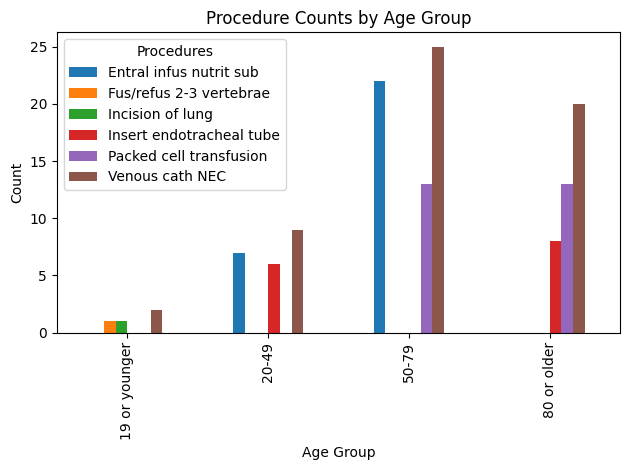

In [ ]:
# Bar graph of the number of occurrences of each procedure by age group
procs_by_age_pivot = procs_by_age.pivot(index='age_group', columns='top_3_procedures', values='procedure_count').fillna(0)

plt.figure(figsize=(10, 6))
procs_by_age_pivot.plot(kind='bar')
plt.title('Procedure Counts by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Count')
plt.legend(title='Procedures')
plt.tight_layout()
plt.show()


For all age groups, venous cath NEC is the most common procedure.

# Analysis Question 3: How long do patients stay in the ICU? Is there a difference in the ICU length of stay among gender or ethnicity?

In [5]:
# How long do patients stay in the ICU
conn.sql(
    """
    ALTER TABLE ICUSTAYS
    ADD COLUMN hours_of_stay NUMERIC;

    """
)

conn.sql("""
UPDATE icustays
SET hours_of_stay = ROUND(EXTRACT(EPOCH FROM CAST(outtime AS TIMESTAMP) - CAST(intime AS TIMESTAMP)) / 3600.0, 1);
""")

In [6]:
# Convert to csv to be used in part ii
conn.sql(
    """
    SELECT * FROM ICUSTAYS;
    """
).df().to_csv('ICUSTAYS_W_HOURS.csv')

In [19]:
# Determine hours of stay with regards to ethnicity and gender
hours_gender_ethnicity = conn.sql(
    """
    SELECT PATIENTS.gender, ADMISSIONS.ethnicity, ICUSTAYS.hours_of_stay
    FROM ICUSTAYS JOIN PATIENTS
    ON ICUSTAYS.subject_id = PATIENTS.subject_id
    JOIN ADMISSIONS ON ICUSTAYS.hadm_id = ADMISSIONS.hadm_id
    ORDER BY ADMISSIONS.ethnicity;
    """
).df()

hours_gender_ethnicity

,gender,ethnicity,hours_of_stay
0,M,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,30.3
1,M,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,513.9
2,F,ASIAN,15.9
3,M,ASIAN,170.8
4,F,BLACK/AFRICAN AMERICAN,39.2
...,...,...,...
131,M,WHITE,27.5
132,F,WHITE,51.4
133,M,WHITE,25.0
134,F,WHITE,47.2


<Figure size 800x500 with 0 Axes>

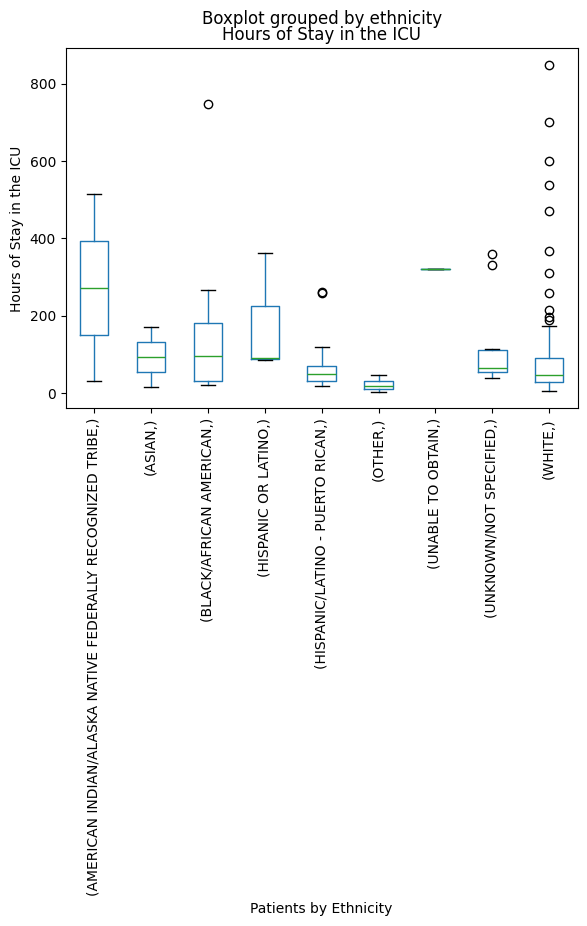

In [20]:
# Plot trends of hours of stay for ethnicity
plt.figure(figsize=(8, 5))
hours_gender_ethnicity.boxplot(by = ['ethnicity'], column=['hours_of_stay'], grid=False)
plt.title('Hours of Stay in the ICU')
plt.xlabel('Patients by Ethnicity')
plt.ylabel('Hours of Stay in the ICU')
plt.xticks(rotation=90)
plt.show()


White patients have the widest range of hours spent in the ICU while American Indian and Unable to Obtain have the highest average number of hours spent in the ICU.

<Figure size 800x500 with 0 Axes>

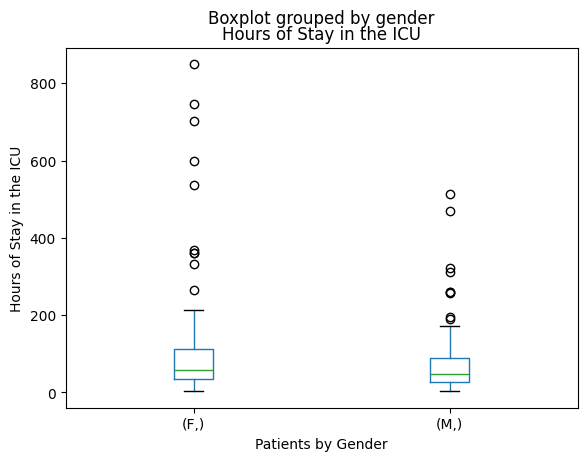

In [12]:
# Plot trends of hours of stay by gender
plt.figure(figsize=(8, 5))
hours_gender_ethnicity.boxplot(by = ['gender'], column=['hours_of_stay'], grid=False)
plt.title('Hours of Stay in the ICU')
plt.xlabel('Patients by Gender')
plt.ylabel('Hours of Stay in the ICU')
plt.show()

Females have both a higher average and wider range of hours spent in the ICU compared to males.

In [23]:
# Calculate average hours of stay by ethnicity and gender
avg_hours_gender_ethnicity = conn.sql(
  """
    SELECT
        PATIENTS.gender,
        ADMISSIONS.ethnicity,
        ROUND(AVG(ICUSTAYS.hours_of_stay),1) AS average_hours_of_stay
    FROM ICUSTAYS
    JOIN PATIENTS ON ICUSTAYS.subject_id = PATIENTS.subject_id
    JOIN ADMISSIONS ON ICUSTAYS.hadm_id = ADMISSIONS.hadm_id
    GROUP BY ADMISSIONS.ethnicity, PATIENTS.gender
    ORDER BY average_hours_of_stay DESC;
  """
).df()

avg_hours_gender_ethnicity

,gender,ethnicity,average_hours_of_stay
0,M,UNABLE TO OBTAIN,320.6
1,M,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,272.1
2,F,BLACK/AFRICAN AMERICAN,268.9
3,F,HISPANIC OR LATINO,179.0
4,M,ASIAN,170.8
5,F,UNKNOWN/NOT SPECIFIED,133.0
6,F,WHITE,124.7
7,M,HISPANIC/LATINO - PUERTO RICAN,77.8
8,M,WHITE,75.7
9,M,BLACK/AFRICAN AMERICAN,71.4


<Figure size 1000x600 with 0 Axes>

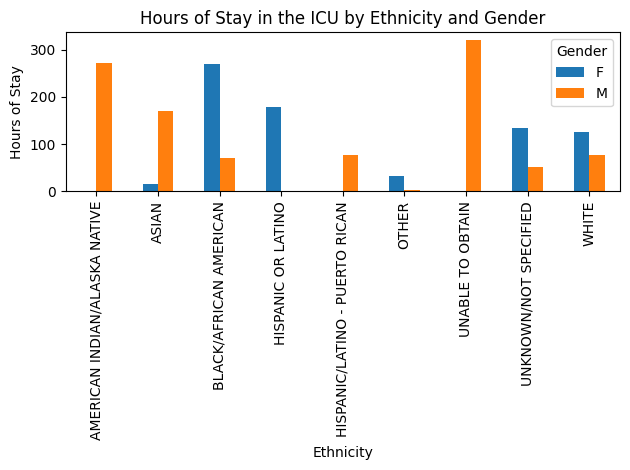

In [24]:
# Plot average hours of stay by ethnicity and gender
avg_hours_gender_ethnicity.loc[avg_hours_gender_ethnicity['ethnicity'] == "AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE", 'ethnicity'] = "AMERICAN INDIAN/ALASKA NATIVE"
avg_hours_gender_ethnicity_pivot = avg_hours_gender_ethnicity.pivot(index='ethnicity', columns='gender', values='average_hours_of_stay').fillna(0)

plt.figure(figsize=(10, 6))
avg_hours_gender_ethnicity_pivot.plot(kind='bar')
plt.title('Hours of Stay in the ICU by Ethnicity and Gender')
plt.xlabel('Ethnicity')
plt.ylabel('Hours of Stay')
plt.legend(title='Gender')
plt.tight_layout()
plt.show()

Females of most ethnicities tend to have longer ICU Stays than men except for Asian patients where males have much longer average stays. Black females have proportionally longer ICU stays than black males compared to other ethnicities.

In [15]:
# Determine average hours of stay by gender
conn.sql(
    """
    SELECT PATIENTS.gender, ROUND(AVG(hours_of_stay),1) as hours_of_stay
    FROM ICUSTAYS JOIN PATIENTS
    ON ICUSTAYS.subject_id = PATIENTS.subject_id
    GROUP BY PATIENTS.gender
    ORDER BY PATIENTS.gender;
    """
).df()

,gender,hours_of_stay
0,F,133.0
1,M,84.3


In [21]:
# Determine average hours of stay by ethnicity
average_stay_ethnicity =conn.sql(
    """
    SELECT ADMISSIONS.ethnicity,
    ROUND(AVG(hours_of_stay),1) as hours_of_stay
    FROM ICUSTAYS JOIN ADMISSIONS
    ON ICUSTAYS.hadm_id = ADMISSIONS.hadm_id
    GROUP BY ADMISSIONS.ethnicity
    ORDER BY hours_of_stay DESC;
    """
).df()

average_stay_ethnicity

,ethnicity,hours_of_stay
0,UNABLE TO OBTAIN,320.6
1,AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGN...,272.1
2,BLACK/AFRICAN AMERICAN,184.2
3,HISPANIC OR LATINO,179.0
4,UNKNOWN/NOT SPECIFIED,118.2
5,WHITE,99.1
6,ASIAN,93.4
7,HISPANIC/LATINO - PUERTO RICAN,77.8
8,OTHER,22.2


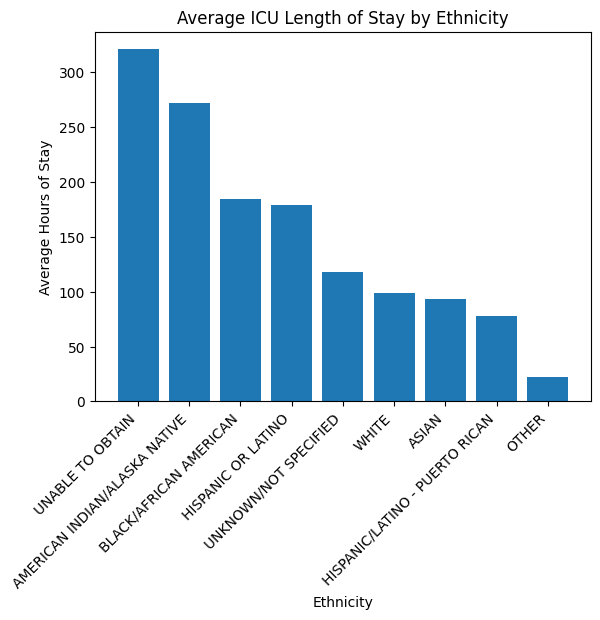

In [25]:
# Plot average hours of stay by ethnicity
average_stay_ethnicity.loc[average_stay_ethnicity['ethnicity'] == "AMERICAN INDIAN/ALASKA NATIVE FEDERALLY RECOGNIZED TRIBE", 'ethnicity'] = "AMERICAN INDIAN/ALASKA NATIVE"

plt.bar(average_stay_ethnicity['ethnicity'], average_stay_ethnicity['hours_of_stay'])

plt.title("Average ICU Length of Stay by Ethnicity")
plt.xlabel("Ethnicity")
plt.ylabel("Average Hours of Stay")
plt.xticks(rotation=45, ha='right')
plt.show()


Of the specified ethnicities, American Indian patients have the longest average stays and Puerto Rican patients have the shortest average stay in the ICU.